In [80]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [156]:
path = 'data_az/' 
def pre_process(path, surface):
    all_files = glob.glob(os.path.join(path , "**/AccelerometerUncalibrated.csv"))

    dict_types = {'time':'float', 'dt':'float', 'x':'float', 'y':'float', 'z':'float'}
    dfs = list()
    for f in all_files:
        data = pd.read_csv(f, names=['time', 'dt', 'z', 'y', 'x'], skiprows=[0], header=None, dtype = dict_types)
        folder = f.split('/')[1]
        data['activity'] = folder.split('-')[0]
        dfs.append(data)
    df = pd.concat(dfs, ignore_index=True)

    # remove data <5s and >55s
    df = df[df.dt >= 5]
    df = df[df.dt <= 55]

    # surface from which data came
    if surface=='table': 
        df = df[df.activity.str.contains('table')]
    elif surface=='lap':
        df = df[df.activity.str.contains('lap') | df.activity.str.contains('free')]
    elif surface == 'x': # x for don't care
        # regroup activities 
        df['activity'] = df.activity.str.replace(r'_free$', '')
        df['activity'] = df.activity.str.replace(r'_lap$', '')
        df['activity'] = df.activity.str.replace(r'_table$', '')

    # normalize data
    # data preprocessing
    # normalize each channel of accelerometer to zero mean and standard deviation of one by subtracting mean and dividing by standard deviation
    x_mean = np.mean(df['x'])
    x_std = np.std(df['x'])
    y_mean = np.mean(df['y'])
    y_std = np.std(df['y'])
    z_mean = np.mean(df['z'])
    z_std = np.std(df['z'])

    df['x'] = df['x'].apply(lambda x: (x - x_mean)/x_std)
    df['y'] = df['y'].apply(lambda y: (y - y_mean)/y_std)
    df['z'] = df['z'].apply(lambda z: (z - z_mean)/z_std)
    return df

In [101]:
def extract_features(df):
    # DATA SEGMENTATION
    # segment data into windows of length 512 with 256 samples overlapping between consecutive windows
    x_list = [] # 350 x 512 (350 windows, each window of length 512)
    y_list = []
    z_list = []
    labels = []
    frame_size = 128
    hop_size = 64
    for i in range(0, len(df) - frame_size, hop_size):

        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Use most often used label in this segment as the label for the overall frame
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
        labels.append(label)
    
    # FEATURE EXTRACTION
    # extract mean, std, fft energy and correlation of each window
    # selected these features due to this paper https://www.aaai.org/Papers/IAAI/2005/IAAI05-013.pdf
    X = pd.DataFrame()
    y = labels
    # mean of each window
    X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean()) 
    X['y_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X['z_mean'] = pd.Series(x_list).apply(lambda x: x.mean())

    # standard deviation
    X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # FFT energy
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])

    X['x_fft_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
    X['y_fft_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
    X['z_fft_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))

    # correlation
    corr_xy_list = []
    corr_yz_list = []
    corr_xz_list = []

    for i in range(0, len(x_list)):
        corr_xy, _ = pearsonr(x_list[i], y_list[i])
        corr_yz, _ = pearsonr(y_list[i], z_list[i])
        corr_xz, _ = pearsonr(x_list[i], z_list[i])

        corr_xy_list.append(corr_xy)
        corr_yz_list.append(corr_yz)
        corr_xz_list.append(corr_xz)
    X['xy_corr'] = corr_xy_list
    X['yz_corr'] = corr_yz_list
    X['xz_corr'] = corr_xz_list

    return (X, y)

/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_43645/3472378697.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]


Random forest classifier: 
mean precision: 0.9648605111334557 mean recall: 0.9654255319148937 mean F1 score: 0.9649294230188363 


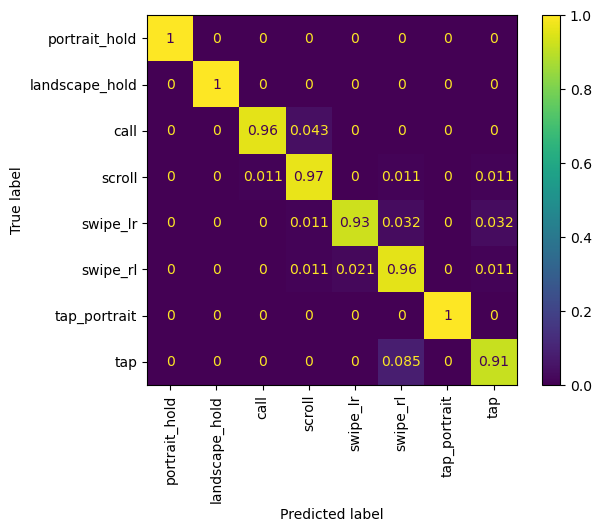

In [160]:
# classify data where hands with phone placed anywhere
df = pre_process(path, surface='x')
X, y = extract_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = ['portrait_hold', 'landscape_hold', 'call', 'scroll', 'swipe_lr', 'swipe_rl', 'tap_portrait', 'tap']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()

/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_43645/3472378697.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]


Random forest classifier: 
mean precision: 0.9764078674948239 mean recall: 0.9759371833839919 mean F1 score: 0.975836486665982 


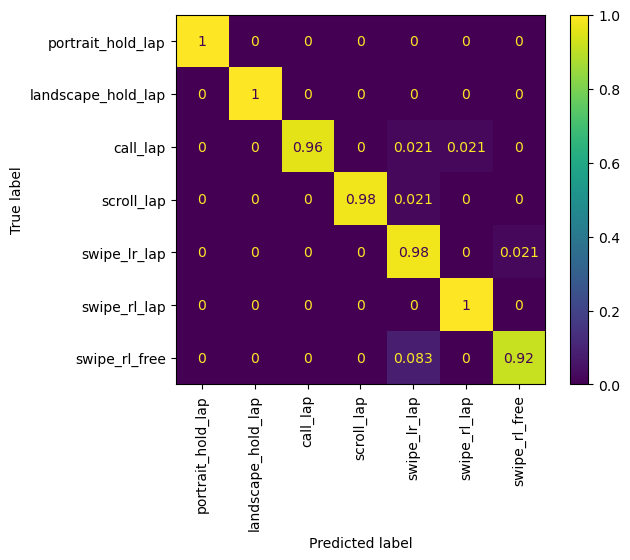

In [136]:
# classify data where hands with phone rested on lap or on nothing 
df = pre_process(path, surface='lap')
X, y = extract_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = ['portrait_hold_lap', 'landscape_hold_lap', 'call_lap', 'scroll_lap', 'swipe_lr_lap', 'swipe_rl_lap', 'swipe_rl_free']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()

/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_43645/3472378697.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]


Random forest classifier: 
mean precision: 0.976102669328601 mean recall: 0.976063829787234 mean F1 score: 0.9759753466327108 


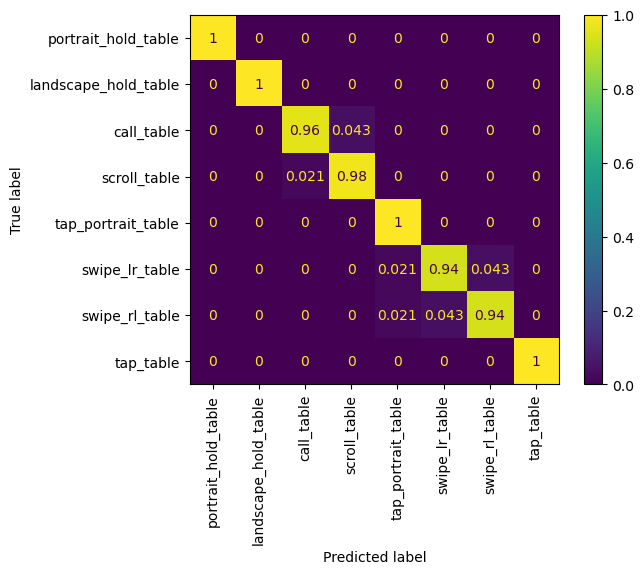

In [104]:
# classify data where hands rested on table with phone
df = pre_process(path, surface='table')
X, y = extract_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = ['portrait_hold_table', 'landscape_hold_table', 'call_table', 'scroll_table', 'tap_portrait_table', 'swipe_lr_table', 'swipe_rl_table', 'tap_table']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()